<a href="https://colab.research.google.com/github/ptonydb/hair-seg/blob/main/hair-segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl 

     |████████████████████████████████| 592.3MB 108.1MB/s 
ERROR: torchvision 0.4.2 has requirement torch==1.3.1, but you'll have torch 0.3.0.post4 which is incompatible.
ERROR: fastai 1.0.59 has requirement torch>=1.0.0, but you'll have torch 0.3.0.post4 which is incompatible.
  Found existing installation: torch 1.3.1
    Uninstalling torch-1.3.1:
      Successfully uninstalled torch-1.3.1


# New Section

In [ ]:
!pip3 install torchvision

     |████████████████████████████████| 734.6MB 23kB/s 
  Found existing installation: torch 0.3.0.post4
    Uninstalling torch-0.3.0.post4:
      Successfully uninstalled torch-0.3.0.post4


In [ ]:
from google.colab import drive
drive.mount('/drive')
%cd /drive/My Drive/as3

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /drive
/drive/My Drive/as3


In [ ]:
import math

import torch.nn as nn

def conv_bn(inp, oup, stride):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )


def conv_1x1_bn(inp, oup):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )


class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio):
        super(InvertedResidual, self).__init__()
        self.stride = stride
        assert stride in [1, 2]

        hidden_dim = round(inp * expand_ratio)
        self.use_res_connect = self.stride == 1 and inp == oup

        if expand_ratio == 1:
            self.conv = nn.Sequential(
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        else:
            self.conv = nn.Sequential(
                # pw
                nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)


class MobileNetV2(nn.Module):
    def __init__(self, n_class=1000, input_size=224, width_mult=1.):
        super(MobileNetV2, self).__init__()
        block = InvertedResidual
        input_channel = 32
        last_channel = 1280
        interverted_residual_setting = [
            # t, c, n, s
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            [6, 32, 3, 2],
            [6, 64, 4, 2],
            [6, 96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1],
        ]

        # building first layer
        assert input_size % 32 == 0
        input_channel = int(input_channel * width_mult)
        self.last_channel = int(last_channel * width_mult) if width_mult > 1.0 else last_channel
        self.features = [conv_bn(3, input_channel, 2)]
        # building inverted residual blocks
        for t, c, n, s in interverted_residual_setting:
            output_channel = int(c * width_mult)
            for i in range(n):
                if i == 0:
                    self.features.append(block(input_channel, output_channel, s, expand_ratio=t))
                else:
                    self.features.append(block(input_channel, output_channel, 1, expand_ratio=t))
                input_channel = output_channel
        # building last several layers
        self.features.append(conv_1x1_bn(input_channel, self.last_channel))
        # make it nn.Sequential
        self.features = nn.Sequential(*self.features)

        # building classifier
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(self.last_channel, n_class),
        )

        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = x.mean(3).mean(2)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                n = m.weight.size(1)
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()


In [ ]:
import logging
import math
import sys

import torch
import torch.nn as nn
from torch.nn.functional import interpolate



class MobileNetV2_unet(nn.Module):
    def __init__(self, pre_trained='weights/mobilenet_v2.pth.tar'):
        super(MobileNetV2_unet, self).__init__()

        self.backbone = MobileNetV2()

        self.dconv1 = nn.ConvTranspose2d(1280, 96, 4, padding=1, stride=2)
        self.invres1 = InvertedResidual(192, 96, 1, 6)

        self.dconv2 = nn.ConvTranspose2d(96, 32, 4, padding=1, stride=2)
        self.invres2 = InvertedResidual(64, 32, 1, 6)

        self.dconv3 = nn.ConvTranspose2d(32, 24, 4, padding=1, stride=2)
        self.invres3 = InvertedResidual(48, 24, 1, 6)

        self.dconv4 = nn.ConvTranspose2d(24, 16, 4, padding=1, stride=2)
        self.invres4 = InvertedResidual(32, 16, 1, 6)

        self.conv_last = nn.Conv2d(16, 3, 1)

        self.conv_score = nn.Conv2d(3, 1, 1)

        self._init_weights()

        if pre_trained is not None:
            self.backbone.load_state_dict(torch.load(pre_trained))

    def forward(self, x):
        for n in range(0, 2):
            x = self.backbone.features[n](x)
        x1 = x
        logging.debug((x1.shape, 'x1'))

        for n in range(2, 4):
            x = self.backbone.features[n](x)
        x2 = x
        logging.debug((x2.shape, 'x2'))

        for n in range(4, 7):
            x = self.backbone.features[n](x)
        x3 = x
        logging.debug((x3.shape, 'x3'))

        for n in range(7, 14):
            x = self.backbone.features[n](x)
        x4 = x
        logging.debug((x4.shape, 'x4'))

        for n in range(14, 19):
            x = self.backbone.features[n](x)
        x5 = x
        logging.debug((x5.shape, 'x5'))

        up1 = torch.cat([
            x4,
            self.dconv1(x)
        ], dim=1)
        up1 = self.invres1(up1)
        logging.debug((up1.shape, 'up1'))

        up2 = torch.cat([
            x3,
            self.dconv2(up1)
        ], dim=1)
        up2 = self.invres2(up2)
        logging.debug((up2.shape, 'up2'))

        up3 = torch.cat([
            x2,
            self.dconv3(up2)
        ], dim=1)
        up3 = self.invres3(up3)
        logging.debug((up3.shape, 'up3'))

        up4 = torch.cat([
            x1,
            self.dconv4(up3)
        ], dim=1)
        up4 = self.invres4(up4)
        logging.debug((up4.shape, 'up4'))

        x = self.conv_last(up4)
        logging.debug((x.shape, 'conv_last'))

        # x = self.conv_score(x)
        # logging.debug((x.shape, 'conv_score'))

        x = interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
        logging.debug((x.shape, 'interpolate'))

        # x = torch.sigmoid(x)

        return x

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()


if __name__ == '__main__':
    # Debug
    logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)
    net = MobileNetV2_unet(pre_trained=None)
    net(torch.randn(1, 3, 224, 224))


DEBUG:root:(torch.Size([1, 16, 112, 112]), 'x1')
DEBUG:root:(torch.Size([1, 24, 56, 56]), 'x2')
DEBUG:root:(torch.Size([1, 32, 28, 28]), 'x3')
DEBUG:root:(torch.Size([1, 96, 14, 14]), 'x4')
DEBUG:root:(torch.Size([1, 1280, 7, 7]), 'x5')
DEBUG:root:(torch.Size([1, 96, 14, 14]), 'up1')
DEBUG:root:(torch.Size([1, 32, 28, 28]), 'up2')
DEBUG:root:(torch.Size([1, 24, 56, 56]), 'up3')
DEBUG:root:(torch.Size([1, 16, 112, 112]), 'up4')
DEBUG:root:(torch.Size([1, 3, 112, 112]), 'conv_last')
DEBUG:root:(torch.Size([1, 3, 224, 224]), 'interpolate')


In [ ]:
from glob import glob
import numpy as np
import cv2
from PIL import Image
from torchvision import transforms
import torch
from skimage.transform import resize


# load pre-trained model and weights
def load_model():
    model = MobileNetV2_unet(None)
    state_dict = torch.load('model.pt', map_location='cpu')
    model.load_state_dict(state_dict)
    model.eval()
    return model


if __name__ == '__main__':
    import argparse
    import matplotlib.pyplot as plt

    data_folder = 'test/testing_images/'
    TEST_SIZE = 927

    image_files = sorted(glob('{}/*.jp*g'.format(data_folder)))
    model = load_model()
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ])
    print('Model loaded')
    print(len(image_files), ' files in folder ', data_folder)

    fig = plt.figure()
    preds_test_resized = []
    for i, image_file in enumerate(image_files):
        if i >= TEST_SIZE:
            break

        image = cv2.imread(image_file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        pil_img = Image.fromarray(image)
        torch_img = transform(pil_img)
        torch_img = torch_img.unsqueeze(0)

        # Forward Pass
        logits = model(torch_img)
        mask = np.argmax(logits.data.cpu().numpy(), axis=1)
        preds_test_resized.append(resize(np.squeeze(mask), 
                                       (250, 250), 
                                       mode='constant', preserve_range=True))
        #print(i)
        #print(preds_test_resized[i].shape)
        #print(preds_test_resized[i].ndim)
        #print(preds_test_resized[i].size)
        #print(preds_test_resized[i].dtype)
        # Plot
        #ax = plt.subplot(2, TEST_SIZE, 2 * i + 1)
        #ax.axis('off')
        #ax.imshow(image.squeeze())

        #ax = plt.subplot(2, TEST_SIZE, 2 * i + 2)
        #ax.axis('off')
        #ax.imshow(preds_test_resized[i])

    #plt.show()

Model loaded
927  files in folder  test/testing_images/
DEBUG:root:(torch.Size([1, 16, 128, 128]), 'x1')
DEBUG:root:(torch.Size([1, 24, 64, 64]), 'x2')
DEBUG:root:(torch.Size([1, 32, 32, 32]), 'x3')
DEBUG:root:(torch.Size([1, 96, 16, 16]), 'x4')
DEBUG:root:(torch.Size([1, 1280, 8, 8]), 'x5')
DEBUG:root:(torch.Size([1, 96, 16, 16]), 'up1')
DEBUG:root:(torch.Size([1, 32, 32, 32]), 'up2')
DEBUG:root:(torch.Size([1, 24, 64, 64]), 'up3')
DEBUG:root:(torch.Size([1, 16, 128, 128]), 'up4')
DEBUG:root:(torch.Size([1, 3, 128, 128]), 'conv_last')
DEBUG:root:(torch.Size([1, 3, 256, 256]), 'interpolate')
DEBUG:root:(torch.Size([1, 16, 128, 128]), 'x1')
DEBUG:root:(torch.Size([1, 24, 64, 64]), 'x2')
DEBUG:root:(torch.Size([1, 32, 32, 32]), 'x3')
DEBUG:root:(torch.Size([1, 96, 16, 16]), 'x4')
DEBUG:root:(torch.Size([1, 1280, 8, 8]), 'x5')
DEBUG:root:(torch.Size([1, 96, 16, 16]), 'up1')
DEBUG:root:(torch.Size([1, 32, 32, 32]), 'up2')
DEBUG:root:(torch.Size([1, 24, 64, 64]), 'up3')
DEBUG:root:(torch.Si

<Figure size 432x288 with 0 Axes>

In [ ]:
from skimage.morphology import label
import pandas as pd

def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.75):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

new_test_ids = []
rles = []
for i in range(927):
    rle = list(prob_to_rles(preds_test_resized[i]))
    rles.extend(rle)
    new_test_ids.append('test_mask_' + str(i+1))

new_test_ids.sort()

# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('testm-4.csv', index=False)

DEBUG:root:(torch.Size([1, 16, 128, 128]), 'x1')
DEBUG:root:(torch.Size([1, 24, 64, 64]), 'x2')
DEBUG:root:(torch.Size([1, 32, 32, 32]), 'x3')
DEBUG:root:(torch.Size([1, 96, 16, 16]), 'x4')
DEBUG:root:(torch.Size([1, 1280, 8, 8]), 'x5')
DEBUG:root:(torch.Size([1, 96, 16, 16]), 'up1')
DEBUG:root:(torch.Size([1, 32, 32, 32]), 'up2')
DEBUG:root:(torch.Size([1, 24, 64, 64]), 'up3')
DEBUG:root:(torch.Size([1, 16, 128, 128]), 'up4')
DEBUG:root:(torch.Size([1, 3, 128, 128]), 'conv_last')
DEBUG:root:(torch.Size([1, 3, 256, 256]), 'interpolate')


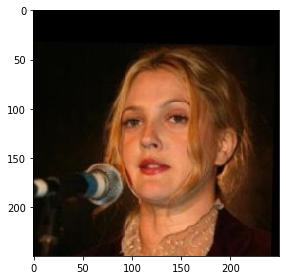

DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fe3ebf12780>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fe3ebf12780>
DEBUG:matplotlib.colorbar:Setting pcolormesh


/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:78: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


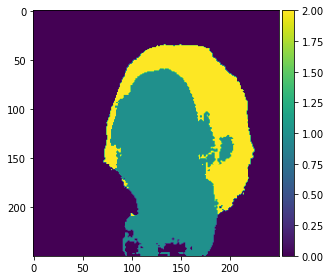

DEBUG:root:(torch.Size([1, 16, 128, 128]), 'x1')
DEBUG:root:(torch.Size([1, 24, 64, 64]), 'x2')
DEBUG:root:(torch.Size([1, 32, 32, 32]), 'x3')
DEBUG:root:(torch.Size([1, 96, 16, 16]), 'x4')
DEBUG:root:(torch.Size([1, 1280, 8, 8]), 'x5')
DEBUG:root:(torch.Size([1, 96, 16, 16]), 'up1')
DEBUG:root:(torch.Size([1, 32, 32, 32]), 'up2')
DEBUG:root:(torch.Size([1, 24, 64, 64]), 'up3')
DEBUG:root:(torch.Size([1, 16, 128, 128]), 'up4')
DEBUG:root:(torch.Size([1, 3, 128, 128]), 'conv_last')
DEBUG:root:(torch.Size([1, 3, 256, 256]), 'interpolate')


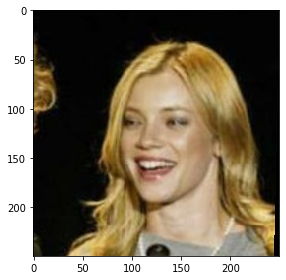

DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fe3eb44ca20>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fe3eb44ca20>
DEBUG:matplotlib.colorbar:Setting pcolormesh


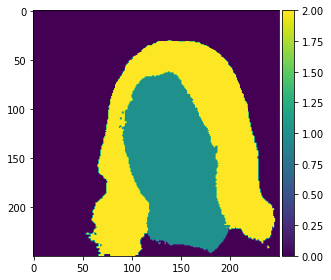

DEBUG:root:(torch.Size([1, 16, 128, 128]), 'x1')
DEBUG:root:(torch.Size([1, 24, 64, 64]), 'x2')
DEBUG:root:(torch.Size([1, 32, 32, 32]), 'x3')
DEBUG:root:(torch.Size([1, 96, 16, 16]), 'x4')
DEBUG:root:(torch.Size([1, 1280, 8, 8]), 'x5')
DEBUG:root:(torch.Size([1, 96, 16, 16]), 'up1')
DEBUG:root:(torch.Size([1, 32, 32, 32]), 'up2')
DEBUG:root:(torch.Size([1, 24, 64, 64]), 'up3')
DEBUG:root:(torch.Size([1, 16, 128, 128]), 'up4')
DEBUG:root:(torch.Size([1, 3, 128, 128]), 'conv_last')
DEBUG:root:(torch.Size([1, 3, 256, 256]), 'interpolate')


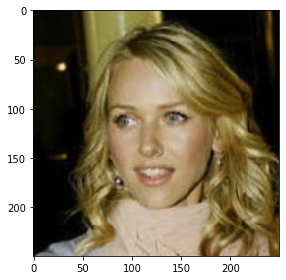

DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fe3eb571cc0>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fe3eb571cc0>
DEBUG:matplotlib.colorbar:Setting pcolormesh


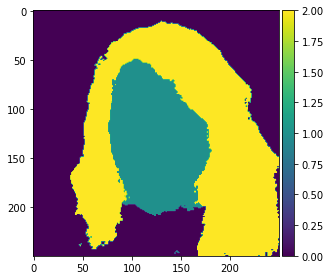

DEBUG:root:(torch.Size([1, 16, 128, 128]), 'x1')
DEBUG:root:(torch.Size([1, 24, 64, 64]), 'x2')
DEBUG:root:(torch.Size([1, 32, 32, 32]), 'x3')
DEBUG:root:(torch.Size([1, 96, 16, 16]), 'x4')
DEBUG:root:(torch.Size([1, 1280, 8, 8]), 'x5')
DEBUG:root:(torch.Size([1, 96, 16, 16]), 'up1')
DEBUG:root:(torch.Size([1, 32, 32, 32]), 'up2')
DEBUG:root:(torch.Size([1, 24, 64, 64]), 'up3')
DEBUG:root:(torch.Size([1, 16, 128, 128]), 'up4')
DEBUG:root:(torch.Size([1, 3, 128, 128]), 'conv_last')
DEBUG:root:(torch.Size([1, 3, 256, 256]), 'interpolate')


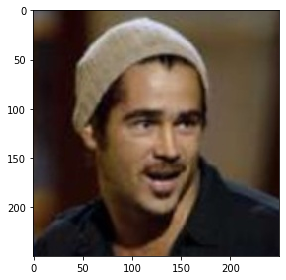

DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fe3eb5fb048>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fe3eb5fb048>
DEBUG:matplotlib.colorbar:Setting pcolormesh


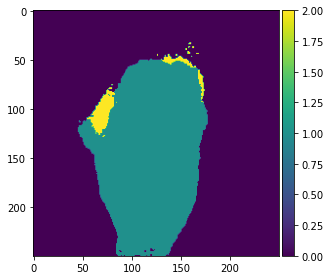

DEBUG:root:(torch.Size([1, 16, 128, 128]), 'x1')
DEBUG:root:(torch.Size([1, 24, 64, 64]), 'x2')
DEBUG:root:(torch.Size([1, 32, 32, 32]), 'x3')
DEBUG:root:(torch.Size([1, 96, 16, 16]), 'x4')
DEBUG:root:(torch.Size([1, 1280, 8, 8]), 'x5')
DEBUG:root:(torch.Size([1, 96, 16, 16]), 'up1')
DEBUG:root:(torch.Size([1, 32, 32, 32]), 'up2')
DEBUG:root:(torch.Size([1, 24, 64, 64]), 'up3')
DEBUG:root:(torch.Size([1, 16, 128, 128]), 'up4')
DEBUG:root:(torch.Size([1, 3, 128, 128]), 'conv_last')
DEBUG:root:(torch.Size([1, 3, 256, 256]), 'interpolate')


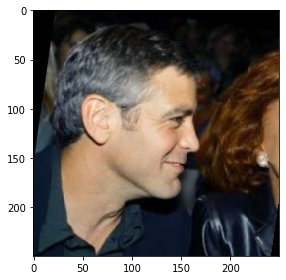

DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fe3eb8f4240>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fe3eb8f4240>
DEBUG:matplotlib.colorbar:Setting pcolormesh


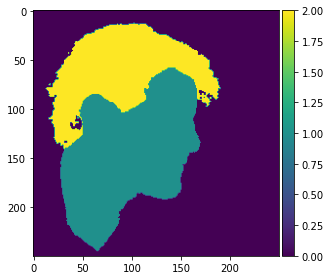

In [ ]:
from skimage.io import imshow

image = cv2.imread(image_files[614])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

pil_img = Image.fromarray(image)
torch_img = transform(pil_img)
torch_img = torch_img.unsqueeze(0)

# Forward Pass
logits = model(torch_img)
mask = np.argmax(logits.data.cpu().numpy(), axis=1)
mask = resize(np.squeeze(mask), (250, 250), mode='constant', preserve_range=True)

imshow(image)
plt.show()
imshow(mask)
plt.show()

image = cv2.imread(image_files[610])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

pil_img = Image.fromarray(image)
torch_img = transform(pil_img)
torch_img = torch_img.unsqueeze(0)

# Forward Pass
logits = model(torch_img)
mask = np.argmax(logits.data.cpu().numpy(), axis=1)
mask = resize(np.squeeze(mask), (250, 250), mode='constant', preserve_range=True)

imshow(image)
plt.show()
imshow(mask)
plt.show()

image = cv2.imread(image_files[752])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

pil_img = Image.fromarray(image)
torch_img = transform(pil_img)
torch_img = torch_img.unsqueeze(0)

# Forward Pass
logits = model(torch_img)
mask = np.argmax(logits.data.cpu().numpy(), axis=1)
mask = resize(np.squeeze(mask), (250, 250), mode='constant', preserve_range=True)

imshow(image)
plt.show()
imshow(mask)
plt.show()

image = cv2.imread(image_files[780])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

pil_img = Image.fromarray(image)
torch_img = transform(pil_img)
torch_img = torch_img.unsqueeze(0)

# Forward Pass
logits = model(torch_img)
mask = np.argmax(logits.data.cpu().numpy(), axis=1)
mask = resize(np.squeeze(mask), (250, 250), mode='constant', preserve_range=True)

imshow(image)
plt.show()
imshow(mask)
plt.show()

image = cv2.imread(image_files[686])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

pil_img = Image.fromarray(image)
torch_img = transform(pil_img)
torch_img = torch_img.unsqueeze(0)

# Forward Pass
logits = model(torch_img)
mask = np.argmax(logits.data.cpu().numpy(), axis=1)
mask = resize(np.squeeze(mask), (250, 250), mode='constant', preserve_range=True)

imshow(image)
plt.show()
imshow(mask)
plt.show()
